In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [74]:
df=pd.read_csv(r'Irish_DataSet\finalDataForResidential.txt',header=None,delimiter=" ")
df.rename(columns={0: "ID", 1: "Month", 2: "Time", 3: "Consumption"},inplace=True)
def convert_date(day):
    base_date = datetime(2009, 1, 1)
    converted_date = base_date + timedelta(days=(day - 195))
    return converted_date

def convert_time(time):
    hours = (time - 1) // 2
    minutes = (time - 1) % 2 * 30
    return f"{(hours):02d}:{(minutes):02d}"

df['Month'] = df['Month'].apply(convert_date)
df

,ID,Month,Time,Consumption
0,1002,2009-01-01,1,0.362
1,1002,2009-01-01,2,0.064
2,1002,2009-01-01,3,0.119
3,1002,2009-01-01,4,0.023
4,1002,2009-01-01,5,0.140
...,...,...,...,...
5873845,1998,2009-06-20,46,1.242
5873846,1998,2009-06-20,47,2.724
5873847,1998,2009-06-20,48,1.853
5873848,1998,2009-06-20,49,0.000


In [13]:
df.isnull().sum(), df.nunique()
# df['Time'] = df['Time'].apply(convert_time)

(ID             0
 Month          0
 Time           0
 Consumption    0
 dtype: int64,
 ID              687
 Month           171
 Time             50
 Consumption    7865
 dtype: int64)

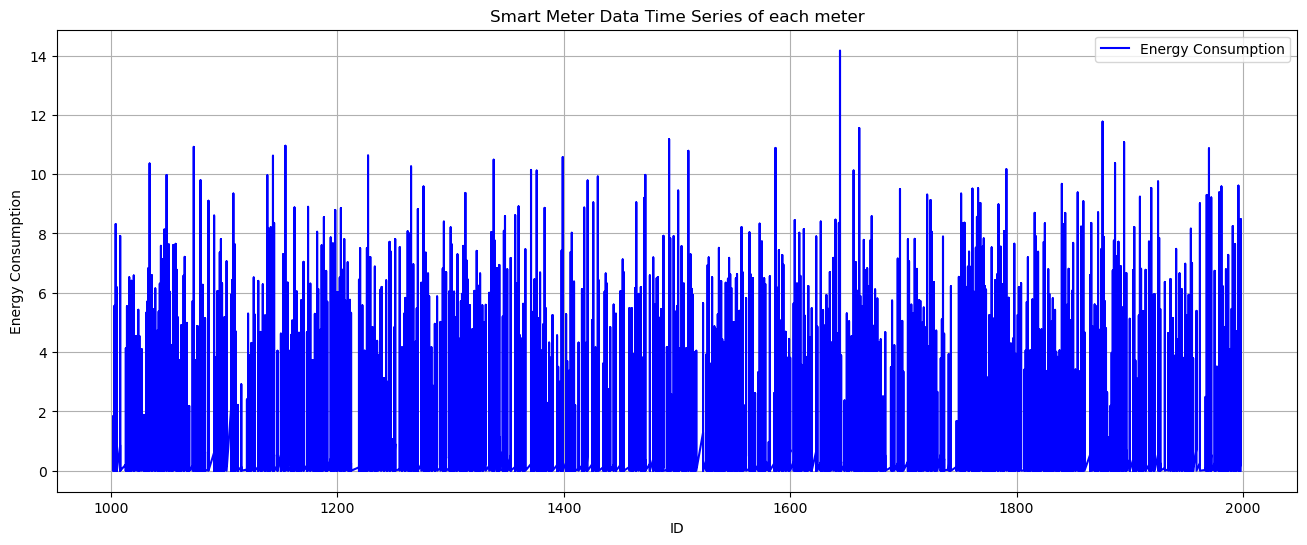

In [26]:
df.set_index("ID", inplace=True)
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Consumption'], label='Energy Consumption', color='blue')
plt.title('Smart Meter Data Time Series of each meter')
plt.xlabel('ID')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

## Box plot for outliers

In [60]:
df.describe()

,ID,Time,Consumption
count,5.873850e+06,5.873850e+06,5.873850e+06
mean,1.509962e+03,2.550000e+01,4.934427e-01
std,2.881979e+02,1.443087e+01,6.943238e-01
min,1.002000e+03,1.000000e+00,0.000000e+00
25%,1.260000e+03,1.300000e+01,1.070000e-01
50%,1.526000e+03,2.550000e+01,2.400000e-01
75%,1.765000e+03,3.800000e+01,5.720000e-01
max,1.998000e+03,5.000000e+01,1.416200e+01


<Axes: xlabel='Consumption'>

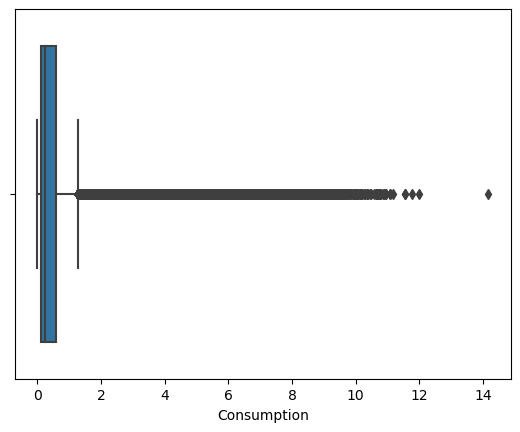

In [63]:
sns.boxplot(x= 'Consumption', data=df)

In [70]:
q1 = df.Consumption.quantile(0.25)
q3 = df.Consumption.quantile(0.75)
print(q1,q3) # 0.107 0.572
IQR = q3-q1
print(IQR) # 0.46499999999999997

lower_fence = q1 - (1.5 * IQR)
upper_fence = q3 + (1.5 * IQR)
print(lower_fence, upper_fence)
# No. of outliers = 5873850 - 5284635 = 5,89,215

0.107 0.572
0.46499999999999997
-0.5905 1.2694999999999999


## Removing the outliers using IQR

C:\Users\HP\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


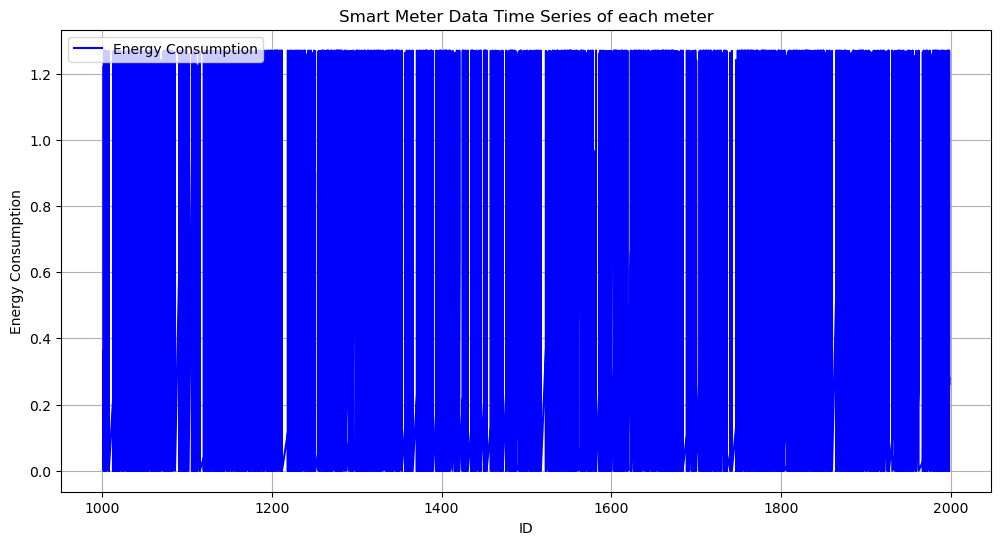

In [75]:
df= df[~((df.Consumption < lower_fence) | (df.Consumption > upper_fence))]

df.set_index("ID", inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Consumption'], label='Energy Consumption', color='blue')
plt.title('Smart Meter Data Time Series of each meter')
plt.xlabel('ID')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

## Standardizing the data

In [76]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df[['Consumption']].values)

## find K using Elbow method 

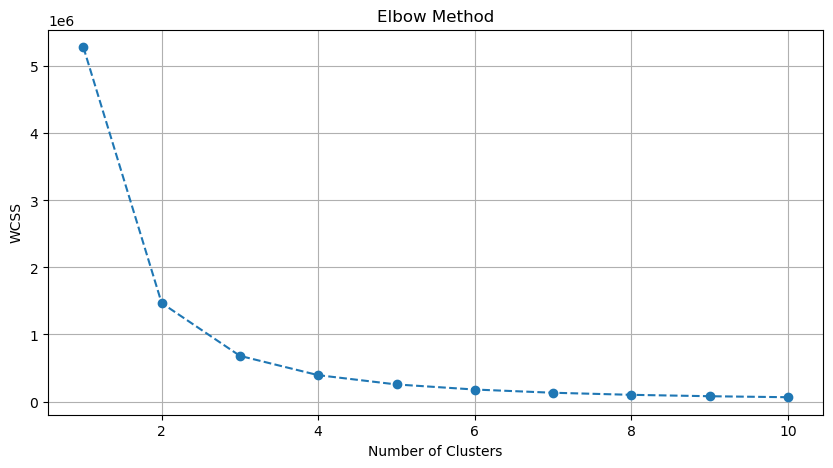

In [77]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_std)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

## K-means clustering

In [78]:
# without train and test 
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10,max_iter=100)
kmeans.fit(X_std)

KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=42)

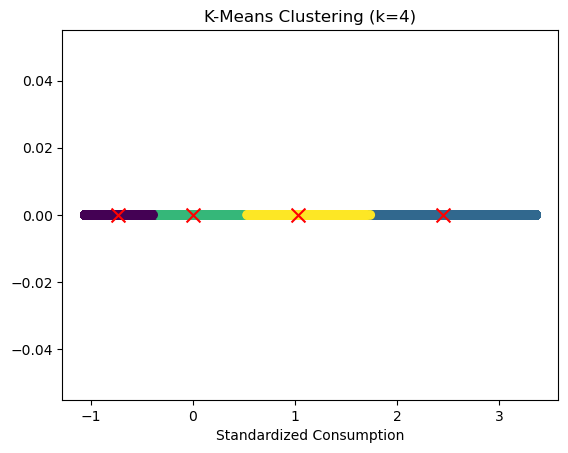

In [79]:
plt.scatter(X_std[:,], [0] * len(X_std), c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,], [0] * len(kmeans.cluster_centers_), c='red', marker='x', s=100)
plt.xlabel('Standardized Consumption')
plt.title(f'K-Means Clustering (k={k})')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_22636\172460491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = cluster_labels
C:\Users\HP\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


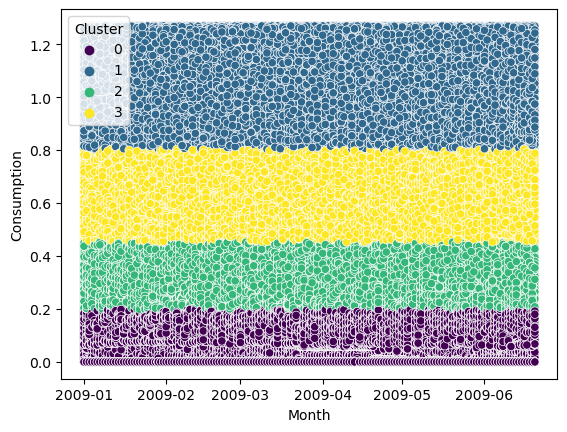

In [81]:
cluster_labels = kmeans.labels_
df['Cluster'] = cluster_labels

sns.scatterplot(data=df, x='Month', y='Consumption', hue='Cluster', palette='viridis', legend=True)
plt.show()
# print("Length of cluster_labels:", len(cluster_labels))

C:\Users\HP\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


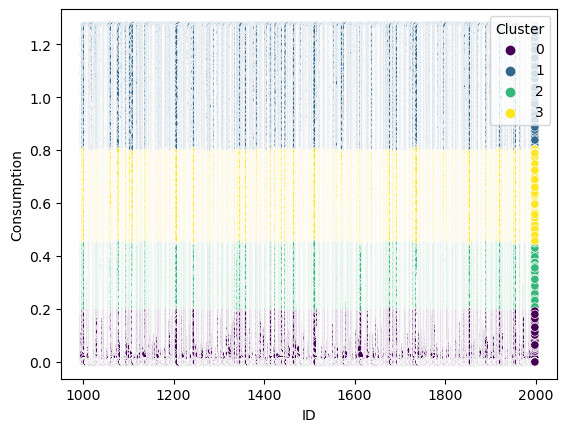

In [84]:
sns.scatterplot(data=df, x='ID', y='Consumption', hue='Cluster', palette='viridis', legend=True)
plt.show()

In [ ]:
sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0,n_init=10,max_iter=100)
    cluster_labels = kmeans.fit_predict(df[['Consumption']])
    silhouette_avg = silhouette_score(df[['Consumption']], cluster_labels)
    sil_scores.append(silhouette_avg)

plt.plot(range(2, 11), sil_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
chosen_k =  4
kmeans = KMeans(n_clusters=chosen_k, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['Consumption']])

plt.scatter(data['ID'], df['Consumption'], c=df['cluster'])
plt.title('K-Means Clustering (k={})'.format(chosen_k))
plt.xlabel('ID')
plt.ylabel('DailyConsumption')
plt.show()

## Training and Testing dataset 

In [7]:
X = df.drop('Consumption', axis=1)  # Features
y = df['Consumption']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4699080, 3), (1174770, 3), (4699080,), (1174770,))

## Standardize the features:

In [14]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Train K-means clustering model with the chosen number of clusters

In [34]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_train_std)
y_pred = kmeans.predict(X_test_std)

## Evaluate the accuracy of the K-means clustering model:

In [39]:
silhouette_avg = silhouette_score(X_test_std, y_pred)

# cluster_labels = kmeans.labels_
# silhouette_avg = silhouette_score(X_train_std, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')

In [37]:
inertia = kmeans.inertia_
print(f'Inertia (within-cluster sum of squares): {inertia:.2f}')

Inertia (within-cluster sum of squares): 5621774.76
